# The "Jeanloz Method" for fitting equations of state to unquenchable phases
## By Matthew C. Brennan
## Based on "Finite Strain Equation of State for High Pressure Phases" by Raymond Jeanloz (Geophysical Research Letters Vol. 8, No. 12, pages 1219-1222, December 1981)

## Variable definitions
#### Note that Jeanloz uses the subscript "02" in the original paper to refer to the high-pressure phase. Since only the high-pressure phase is considered here, I drop that subscript wherever it appears
Pressure: **P**\
Measured density: **rho**\
Extrapolated density at P = 0: **rho_0**\
Arbitrary reference density (placeholder for fitting): **rho_star**\
Measured density normalized to reference density: **rho_norm**\
"Density ration" [sic] relating measured and reference density: **alpha**\
Measured unit cell volume: **V**\
Extrapolated unit cell volume at P = 0: **V_0**\
Bulk modulus at P = 0: **K_0**\
Pressure derivative of bulk modulus at P = 0: **K_prime**\
Effective strain: **g**\
Normalized stress (i.e., normalized P): **G**\
Strain at G = 0: **g_0**\
Strain shifted to pass through g_0: **g_prime**\
Coefficents of G vs g polynomial: **a, b, c, d**\
Coefficents of G vs g_prime polynomial: **lambda_0, lambda_1, lambda_2, lambda_3**

## Step 0: Import packages

In [26]:
import pandas as pd #for tabulating data
import numpy as np #for sqrt function and polyval
import matplotlib.pyplot as plt #for plotting
import scipy #for polynomial fit
from scipy.odr import * #for polynomial fit

In [2]:
#define polynomial function for ODR fit
def G_poly(p,g_value): #p[0] is g^0 coefficent (a or lambda_0), p[1] is g^1 coefficent (b or lambda_1), p[2] is g^2 coefficent (c or lambda_2)
    return p[0] + p[1] * g_value + p[2] * g_value**2
G_function = Model(G_poly)

## Step 1: Get data from Mao et al. (1967) and Mao & Bell (1979)
#### Data contains Pressure (GPa) versus Volume (cm^3/mol) points for hcp-Fe, with uncertainties

In [3]:
#manually enter data
P = [8.0,12.2,13.1,13.1,14.5,18.3,19.2,21.2,21.3,21.6,21.6,21.9,22.0,23.5,23.7,23.8,24.9,26.2,28.3,30.9,43.7,53.8,56.1,73.4,74.5,82.9,86.3,94.1]
P_uncert = [0.16,0.24,0.26,0.26,0.29,0.37,0.38,0.42,0.43,0.43,0.43,0.44,0.44,0.47,0.47,0.48,0.5,0.52,0.57,0.62,2.62,3.23,3.37,4.4,4.47,4.97,5.18,5.65]
V = [6.44,6.32,6.3,6.29,6.24,6.17,6.16,6.1,6.09,6.09,6.11,6.07,6.06,6.04,6.08,6.02,6.01,5.99,5.97,5.89,5.668106,5.53332,5.512038,5.256654,5.334688,5.299218,5.256654,5.128962]
V_uncert = [0.0064,0.0063,0.0063,0.0063,0.0062,0.0062,0.0062,0.0061,0.0061,0.0061,0.0061,0.0061,0.0061,0.006,0.0061,0.006,0.006,0.006,0.006,0.0059,0.017,0.0166,0.0165,0.0158,0.016,0.0159,0.0158,0.0154]

In [4]:
Mao_data = pd.DataFrame({'P': P, 'P_uncert': P_uncert, 'V': V, 'V_uncert': V_uncert})
Mao_data['rho'] = 1/Mao_data['V'] #convert volume to density (mol/cm^3)
Mao_data['rho_uncert'] = (Mao_data['V_uncert']/Mao_data['V']) * Mao_data['rho']

In [5]:
Mao_data

P  P_uncert         V  V_uncert       rho  rho_uncert
0    8.0      0.16  6.440000    0.0064  0.155280    0.000154
1   12.2      0.24  6.320000    0.0063  0.158228    0.000158
2   13.1      0.26  6.300000    0.0063  0.158730    0.000159
3   13.1      0.26  6.290000    0.0063  0.158983    0.000159
4   14.5      0.29  6.240000    0.0062  0.160256    0.000159
5   18.3      0.37  6.170000    0.0062  0.162075    0.000163
6   19.2      0.38  6.160000    0.0062  0.162338    0.000163
7   21.2      0.42  6.100000    0.0061  0.163934    0.000164
8   21.3      0.43  6.090000    0.0061  0.164204    0.000164
9   21.6      0.43  6.090000    0.0061  0.164204    0.000164
10  21.6      0.43  6.110000    0.0061  0.163666    0.000163
11  21.9      0.44  6.070000    0.0061  0.164745    0.000166
12  22.0      0.44  6.060000    0.0061  0.165017    0.000166
13  23.5      0.47  6.040000    0.0060  0.165563    0.000164
14  23.7      0.47  6.080000    0.0061  0.164474    0.000165
15  23.8      0.48  6.020000    0.0060  0.166113    0.000166
16  24.9      0.50  6.010000    0.0060  0.166389    0.000166
17  26.2      0.52  5.990000    0.0060  0.166945    0.000167
18  28.3      0.57  5.970000    0.0060  0.167504    0.000168
19  30.9      0.62  5.890000    0.0059  0.169779    0.000170
20  43.7      2.62  5.668106    0.0170  0.176426    0.000529
21  53.8      3.23  5.533320    0.0166  0.180723    0.000542
22  56.1      3.37  5.512038    0.0165  0.181421    0.000543
23  73.4      4.40  5.256654    0.0158  0.190235    0.000572
24  74.5      4.47  5.334688    0.0160  0.187452    0.000562
25  82.9      4.97  5.299218    0.0159  0.188707    0.000566
26  86.3      5.18  5.256654    0.0158  0.190235    0.000572
27  94.1      5.65  5.128962    0.0154  0.194971    0.000585

## Calculate adjusted parameters
#### Choose arbitrary reference density for hcp-Fe. We will use a value that I've back-calculated to be similar to Jeanloz's (unreported) value:
$$ \rho^* = 0.14108$$
#### Normalize measured density to this value and calculate:
$$ g = \frac{1}{2} \left[ \left( \frac{\rho}{\rho^*} \right) ^{2/3} - 1\right] \qquad \textrm{[7a]}$$
$$ \hat{s}(g) = \frac{1}{3} \frac{\hat{s}(\rho / \rho^*)}{(\rho / \rho^*)^{1/3}} \qquad [14] $$
$$ G = \frac{P}{3(1 + 2g)^{5/2}} \qquad [10] $$
$$ \hat{s}(G) = G \left[ \left( \frac{\hat{s}(P)}{P} \right)^2 + \left( \frac{5 \hat{s}(g)}{1 + 2g} \right)^2 \right]^{1/2} \qquad [13] $$
#### Note that equations are numbered according to the original paper.

In [6]:
rho_star = 0.14108 #arbitrary reference density for high-P phase
Mao_data['rho_norm'] = Mao_data['rho'] / rho_star
Mao_data['rho_norm_uncert'] = Mao_data['rho_uncert'] / rho_star #no extra error from rho_star, so fractional uncertainty is the same
Mao_data['g'] = (1/2) * ( (Mao_data['rho_norm']**(2/3)) - 1) #effective strain [7a]
Mao_data['g_uncert'] = (1/3) * Mao_data['rho_norm_uncert'] / (Mao_data['rho_norm']**(1/3))#[14]
Mao_data['G'] = (1/3) * Mao_data['P'] / (1 + 2*Mao_data['g'])**(5/2) #new normalized P (normalized stress) [10]
Mao_data['G_uncert'] = Mao_data['G'] * ((Mao_data['P_uncert'] / Mao_data['P'])**2 + (5 * Mao_data['g_uncert'] / (1 + 2 * Mao_data['g']))**2)**(1/2) #[13]

## Fit G versus g
$$ G = a + b g + c g^2 + d g^3 + ... \qquad [11] $$
#### In most cases a quadratic fit will be be sufficent. Cubic and higher order terms may be nessessary if the compression range (i.e., the range of g) is very large.
#### The fit coefficents can be defined in terms of thermodynamic variables, see Eq. 12a-d in the text.
#### Jeanloz suggests that "a reasonable wieght for each datum" is the inverse square of its uncertainty in G, but we will do an orthogonal distance regression (ODR) fit to incorportate uncertainty in both G and g.

In [7]:
fit_data = RealData(Mao_data['g'], y = Mao_data['G'], sy = Mao_data['G_uncert'], sx = Mao_data['g_uncert'])
this_odr = ODR(fit_data, G_function, beta0 = [1,1,1]) #beta0 is inital guess for coefficent values
fit = this_odr.run()
#fit.pprint() #show fit output
a, b, c = fit.beta #coefficent values
a_uncert, b_uncert, c_uncert = fit.sd_beta #uncertainties on the coefficents

## Determine g intercept of fit
#### Assuming a quadratic G verus g fit, the g value at which G = 0 is:
$$ g_0 = \frac{(b^2 - 4ac)^{1/2} - b}{2c} \qquad [19b]$$
#### You can propagate error for this but the formula is long so I'm not going to write it out.
#### The "density ration" [sic]
$$ \alpha = (\frac{\rho^*}{\rho_{02}})^{1/3} $$
#### is related to g_0 by
$$ g_0 = \frac{1 - \alpha^2}{2\alpha^2} \qquad [15b] $$
#### therefore (taking the positive root),
$$ \alpha = \frac{1}{(2g_0 +1)^{1/2}} $$

In [8]:
g_0 = ((b**2 - 4*a*c)**(1/2) - b) / (2*c) #root of the G vs g fit [19b]
g_0_uncert = (((b / 2 / np.sqrt(b ** 2 - 4 * a * c) + -1 / 2) ** 2 * b_uncert ** 2 + (2 * (b - np.sqrt(b ** 2 - 4 * a * c)) - 4 * c * a / np.sqrt(b ** 2 - 4 * a * c)) ** 2 * c_uncert ** 2 / 16 / c ** 2) / c ** 2 + a_uncert ** 2 / np.sqrt(b ** 2 - 4 * a * c) ** 2) ** (1 / 2) #uncertainty on g_0
alpha = 1 / (2 * g_0 +1) ** (1/2)

## Shift ordinate axis and refit
#### Shift data in the g direction so that G is a function of g' with the fit passing through the origin
$$ g' = g - g_0 $$
#### Perform another polynomial fit, this time in G versus g':
$$ G = \lambda_0 + \lambda_1 g' + \lambda_2 (g')^2 + \lambda_3 (g')^3 $$
#### A quadratic fit will be sufficent unless you need the second derivative of the bulk modulus (i.e., the fourth-order Birch-Murnaghan).

In [9]:
Mao_data['g_prime'] = Mao_data['g'] - g_0 #change of variable, note that g_uncert is still the error on g_prime

fit_data = RealData(Mao_data['g_prime'], y = Mao_data['G'], sy = Mao_data['G_uncert'], sx = Mao_data['g_uncert'])
this_odr = ODR(fit_data, G_function, beta0 = [1,1,1]) #beta0 is inital guess for coefficent values
fit = this_odr.run()
#fit.pprint() #show fit output
lambda_0, lambda_1, lambda_2 = fit.beta #coefficent values
lambda_0_uncert, lambda_1_uncert, lambda_2_uncert = fit.sd_beta #uncertainties on the coefficents

## Calculate EoS parameters
#### The parameters of interest (the reference density plus the bulk modulus and its derivatives) can now be calculated:
$$ \rho_{0} = \rho^* \alpha^{-3} \qquad [20a] $$
$$ \hat{s}(\rho_{0}) = \hat{s}(\lambda_0) \frac{3 \rho^*}{\alpha \lambda_1} \qquad [20b] $$
$$ K_{0} = \alpha^{-7} \lambda_1 \qquad [21a] $$
$$ \hat{s}(K_0) = \frac{K_0}{\lambda_1}\left[ \hat{s}^2(\lambda_1) - 49\alpha^6\hat{s}^2(\lambda_0)\right] \qquad [21b]$$
$$ K'_0 = \frac{2\lambda_2\alpha^{-2}}{3\lambda_1} + 4 \qquad [22a]$$
$$ \hat{s}(K'_0) = \left(\frac{2}{3\alpha^2\lambda_1}\right) \left[\hat{s}^2(\lambda_2) - \frac{\lambda_2}{\lambda_1}(32\alpha^2\hat{s}^2(\lambda_0)+\hat{s}^2(\lambda_1))\right]^{1/2} \qquad[22b]$$
#### The reference volume is the inverse of the reference density
$$ V_0 = \frac{1}{\rho_0} $$

In [10]:
rho_0 = rho_star * alpha**-3 #[20a]
rho_0_uncert = lambda_0_uncert * 3 * rho_star / (alpha * lambda_1) #[20b]
V_0 = 1/rho_0 #cm^3/mol
V_0_uncert = (rho_0_uncert / rho_0) * V_0
K_0 = lambda_1 * alpha**-7 #[21a]
K_0_uncert = (K_0 / lambda_1) * abs(lambda_1_uncert**2 - 49 * alpha**6 * lambda_0_uncert**2) ** (1/2) #[21b] using absolute value to avoid imaginary results
K_prime = (2/3) * (lambda_2 / lambda_1) * alpha**-2 + 4 #[22a]
K_prime_uncert = (2/(3 * alpha**2 * lambda_1)) * abs(lambda_2_uncert**2 - (lambda_2/lambda_1) * (32 * alpha**2 * lambda_0_uncert**2 + lambda_1_uncert**2))**(1/2) #[22b]

In [11]:
print('Fit EoS Parameters:')
print('\t V_0 = ', round(V_0,3),'±', round(V_0_uncert,3), 'cm^3/mol')
print('\t K_0 =', round(K_0,2),'±', round(K_0_uncert,2), 'GPa')
print('\t K_prime =',round(K_prime,2),'±', round(K_prime_uncert,2))

Fit EoS Parameters:
	 V_0 =  6.723 ± 0.025 cm^3/mol
	 K_0 = 166.12 ± 11.58 GPa
	 K_prime = 5.47 ± 0.66


#### The values fit here match each of Jeanloz values within uncertainty. Differences between the exact values probably arise from differences between our polynomial fitting algorithms.

## Plot
#### This plot reproduces Jeanloz's Figure 1. The inset panel shows a zoomed-in view of the x-intercept.

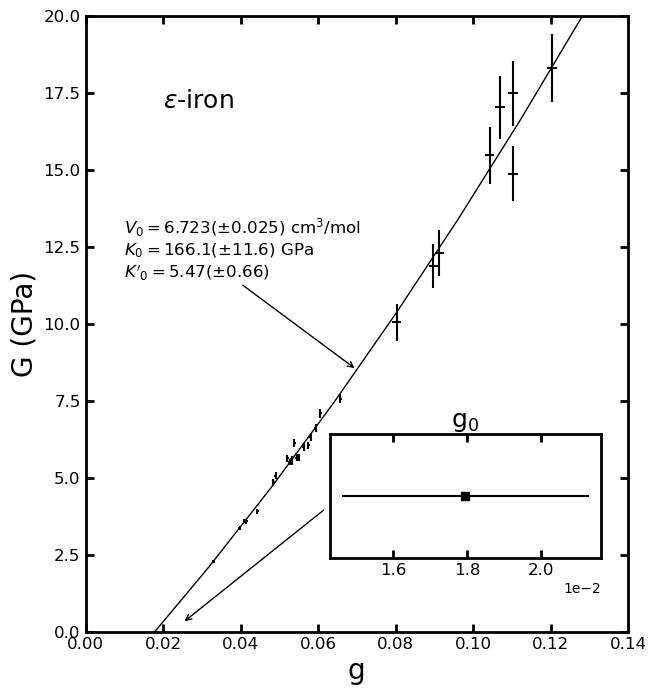

In [17]:
fig = plt.figure(figsize=(7,8))
ax = fig.add_subplot()
ax.errorbar(Mao_data['g'], Mao_data['G'], xerr = Mao_data['g_uncert'], yerr = Mao_data['G_uncert'], linestyle = 'none', color = 'k')
x = np.linspace(0,max(Mao_data['g']*1.2),10)
ax.plot(x, np.polyval([c,b,a],x), color = 'k', linewidth = 1)
ax.set_xlim(0,0.14)
ax.set_ylim(0,20)
ax.set_xlabel('g', fontsize = 20)
ax.set_ylabel('G (GPa)', fontsize = 20)
ax.tick_params(axis='both', direction='in', length=6, labelsize=12, width = 2, top = True, labeltop = False, right = True, labelleft = True)
ax.text(0.02, 17, r'$\epsilon$-iron', fontsize = 18)
ax.text(0.01, 11.5, r'$V_0 =$' + str(round(V_0,3)) + '(±'+ str(round(V_0_uncert,3))+r') cm$^3$/mol'
        +'\n' 
        + r'$K_0 =$' + str(round(K_0,1)) + '(±'+ str(round(K_0_uncert,1))+r') GPa'
        +'\n'
        + '$K\'_0 =$' + str(round(K_prime,2)) + '(±'+ str(round(K_prime_uncert,2))+r')', fontsize = 12)
ax.annotate("", xytext=(0.04, 11.3), xy=(0.07, 8.5),arrowprops=dict(arrowstyle="->"))
ax2 = ax.inset_axes([0.063, 2.4, 0.07, 4], transform=ax.transData)
ax2.errorbar(g_0, 1, xerr = g_0_uncert, marker = 's', color = 'k')
ax2.ticklabel_format(style = 'sci', scilimits=(0,0))
ax2.tick_params(axis='both', direction='in', length=6, labelsize=12, width = 2, top = True, labeltop = False, left = False, labelleft = False)
ax2.set_title(r'g$_0$', fontsize = 18)
ax.annotate("", xytext=(0.062, 4), xy=(0.025, 0.28),arrowprops=dict(arrowstyle="->"))
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
    ax2.spines[axis].set_linewidth(2)

## Function
#### This function performs all of the calculations above and returns the fit parameters and their uncertainties

In [24]:
#remember that you also need the G_poly function from Step 0
def J_fit(P_list, sig_P_list, V_list, sig_V_list):
    my_dict = {'P':P_list, 'P_uncert':sig_P_list, 'V':V_list, 'V_uncert':sig_V_list}
    data = pd.DataFrame(my_dict)
    data['rho'] = 1 / data['V']
    data['rho_uncert'] = data['rho'] * (data['V_uncert'] / data['V'])
    rho_star = min(data['rho']) * 0.9
    data['rho_norm'] = data['rho'] / rho_star
    data['rho_norm_uncert'] = data['rho_uncert'] / rho_star #no extra error from normalizing, just scale
    data['g'] = (1/2) * ( (data['rho_norm']**(2/3)) - 1)   
    data['g'] = (1/2) * ( (data['rho_norm']**(2/3)) - 1) #effective strain 
    data['g_uncert'] = (1/3) * data['rho_norm_uncert'] / (data['rho_norm']**(1/3))
    data['G'] = (1/3) * data['P'] / (1 + 2*data['g'])**(5/2) #new normalized P (normalized stress) 
    data['G_uncert'] = data['G'] * ((data['P_uncert'] / data['P'])**2 + (5 * data['g_uncert'] / (1 + 2 * data['g']))**2)**(1/2)
    fit_data = RealData(data['g'], y = data['G'], sy = data['G_uncert'], sx = data['g_uncert'])
    this_odr = ODR(fit_data, G_function, beta0 = [1,1,1])
    fit = this_odr.run()
    #fit.pprint()
    a, b, c = fit.beta
    g_0 = (abs(b**2 - 4*a*c)**(1/2) - b) / (2*c)
    alpha = 1 / (2 * g_0 + 1) ** (1/2)
    data['g_prime'] = data['g'] - g_0
    fit_data = RealData(data['g_prime'], y = data['G'], sy = data['G_uncert'], sx = data['g_uncert'])
    this_odr = ODR(fit_data, G_function, beta0 = [1,1,1])
    fit = this_odr.run()
    #fit.pprint()
    lambda_0, lambda_1, lambda_2 = fit.beta 
    lambda_0_uncert, lambda_1_uncert, lambda_2_uncert = fit.sd_beta
    rho_0 = rho_star * alpha**-3 #P = 0 density
    rho_0_uncert = lambda_0_uncert * 3 * rho_star / (alpha * lambda_1) #[20b]
    V_0 = 1/rho_0 #P = 0 volume
    V_0_uncert = (rho_0_uncert / rho_0) * V_0      
    K_0 = lambda_1 * alpha**-7           
    K_0_uncert = (K_0 / lambda_1) * abs((lambda_1_uncert**2 - 49 * alpha**6 * lambda_0_uncert**2)) ** (1/2)
    K_prime = (2/3) * (lambda_2 / lambda_1) * alpha**-2 + 4
    K_prime_uncert = (2/(3 * alpha**2 * lambda_1)) * abs((lambda_2_uncert**2 - (lambda_2/lambda_1) * (32 * alpha**2 * lambda_0_uncert**2 + lambda_1_uncert**2)))**(1/2)          
    fit_params = [V_0, K_0, K_prime]
    fit_uncert = [V_0_uncert, K_0_uncert, K_prime_uncert]
    print('Jeanloz fit EoS parameters:')
    print('\t V_0 = ', round(V_0,3),'±', round(V_0_uncert,3), 'cm^3/mol')
    print('\t K_0 =', round(K_0,1),'±', round(K_0_uncert,1), 'GPa')
    print('\t K_prime =',round(K_prime,2),'±', round(K_prime_uncert,2))       
    return fit_params, fit_uncert


In [25]:
J_fit(P,P_uncert,V,V_uncert)

Jeanloz fit EoS parameters:
	 V_0 =  6.723 ± 0.025 cm^3/mol
	 K_0 = 166.1 ± 11.6 GPa
	 K_prime = 5.47 ± 0.66


([6.722829373427487, 166.12199706850345, 5.468381487870769],
 [0.02466356642147748, 11.60890095741453, 0.6625515388632375])

## Legal
#### O4984

#### © 2025. Triad National Security, LLC. All rights reserved. 
#### This program was produced under U.S. Government contract 89233218CNA000001 for Los Alamos National Laboratory (LANL), which is operated by Triad National Security, LLC for the U.S. Department of Energy/National Nuclear Security Administration. All rights in the program are reserved by Triad National Security, LLC, and the U.S. Department of Energy/National Nuclear Security Administration. The Government is granted for itself and others acting on its behalf a nonexclusive, paid-up, irrevocable worldwide license in this material to reproduce, prepare derivative works, distribute copies to the public, perform publicly and display publicly, and to permit others to do so.

#### Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software. 
#### THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
